# Análise de modelos de explicabilidade

## Instalação de dependências

In [ ]:
!pip install interpret
!pip install lime
!pip install dice_ml

In [ ]:
import pandas as pd
import seaborn as sns
import imblearn
import warnings

In [ ]:
from sklearn.model_selection  import train_test_split
from imblearn.over_sampling   import RandomOverSampler
from sklearn.ensemble         import RandomForestClassifier
from sklearn.metrics          import f1_score, accuracy_score
from interpret.blackbox       import LimeTabular
from interpret                import show

In [ ]:
warnings.filterwarnings("ignore", category = FutureWarning, module = "dice_ml")

## Tratamento da base de dados

In [ ]:
import kagglehub

In [ ]:
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction") + "/heart.csv"
!cp -r {path} /content/

Using Colab cache for faster access to the 'heart-failure-prediction' dataset.


In [ ]:
df = pd.read_csv(path); df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [ ]:
# Transforma colunas não-numéricas em colunas de valor binário
columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
encoded = pd.get_dummies(df[columns], prefix=columns, dtype=float)

# Atualiza as colunas com os novos valores
df = pd.concat([encoded, df], axis = 1)
df.drop(columns, axis = 1, inplace = True)

df = df.apply(pd.to_numeric, errors = "coerce")
df = df.fillna(0); df # Preenche valores vazios no dataset

,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,...,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,40,140,289,0,172,0.0,0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,49,160,180,0,156,1.0,1
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,37,130,283,0,98,0.0,0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,48,138,214,0,108,1.5,1
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,54,150,195,0,122,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,45,110,264,0,132,1.2,1
914,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,68,144,193,1,141,3.4,1
915,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,57,130,131,0,115,1.2,1
916,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,57,130,236,0,174,0.0,1


In [ ]:
# Divide o dataset e cria um conjunto de teste e outro de treinamento
def split_df(df):
  # Todas as colunas, com exceção da última, são independentes
  independentes = df.iloc[:,:-1]
  objetivo = df.iloc[:,-1] # Última coluna, HeartDisease, é a coluna de valores objetivo

  return train_test_split(independentes, objetivo, test_size = 0.20, random_state = 2021)

In [ ]:
# Aumenta o conjunto de dados de teste para tamanho proporcional ao de treinamento
def oversample(ind_train, obj_train):
  oversample = RandomOverSampler(sampling_strategy = 'minority')
  x_np = ind_train.to_numpy()
  y_np = obj_train.to_numpy()

  # Executa o oversample
  x_np, y_np = oversample.fit_resample(x_np, y_np)

  ind_over = pd.DataFrame(x_np, columns=ind_train.columns)
  obj_over = pd.Series(y_np, name = obj_train.name)

  return ind_over, obj_over

In [ ]:
# Cria os conjuntos de teste e treinamento
ind_train, ind_test, obj_train, obj_test = split_df(df)

# Faz o oversampling
ind_train, obj_train = oversample(ind_train, obj_train)

## Cria e treina modelo

In [ ]:
rf = RandomForestClassifier() # Usa um modelo genérico
rf.fit(ind_train, obj_train)

# Faz uma predição em cima dos dados de teste
y_pred = rf.predict(ind_test)

print(f"Precisao dos valores previstos pelo modelo: {accuracy_score(obj_test, y_pred)}")

Precisao dos valores previstos pelo modelo: 0.8858695652173914


## LIME

In [ ]:
import lime

In [ ]:
# Aplica o método LIME para explicar resultados do modelo
lime = LimeTabular(rf, ind_train)

# Retorna a explicação do modelo
lime_local = lime.explain_local(ind_test[-20:], obj_test[-20:], name = 'LIME')
show(lime_local)

## SHAP

In [ ]:
import shap

In [ ]:
import xgboost

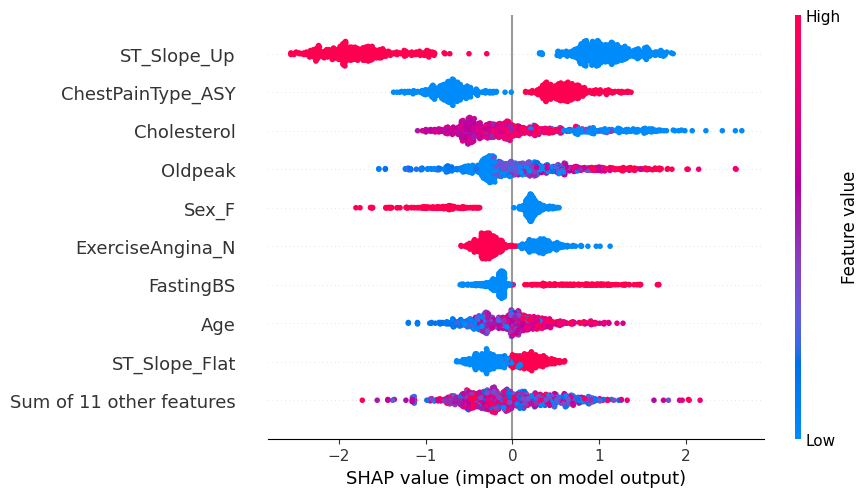

In [ ]:
# Produz um modelo com os dados de treinamento
model = xgboost.XGBClassifier(n_estimators = 20)
model.fit(ind_train, obj_train)

# Produz a explicação do modelo por meio do método SHAP
explainer = shap.Explainer(model)
shap_values = explainer(ind_train)
shap.plots.beeswarm(shap_values)

### Correção de valores no dataset

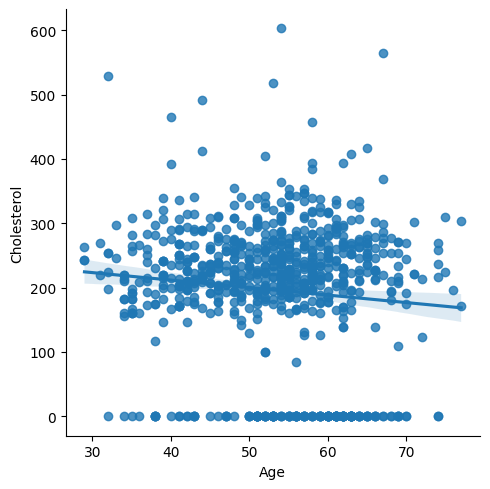

In [ ]:
# 'Cholesterol' possui valores irreais em algumas amostras
sns.lmplot(x = "Age", y = "Cholesterol", data = ind_train)

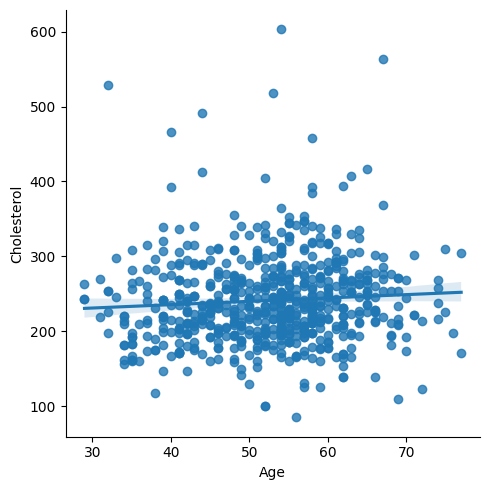

In [ ]:
# Remove todos os indivíduos com valor de colesterol abaixo de 100 mm/dL
new_df = ind_train.drop(ind_train[ind_train['Cholesterol'] < 50].index)
sns.lmplot(x = "Age", y = "Cholesterol", data = new_df)

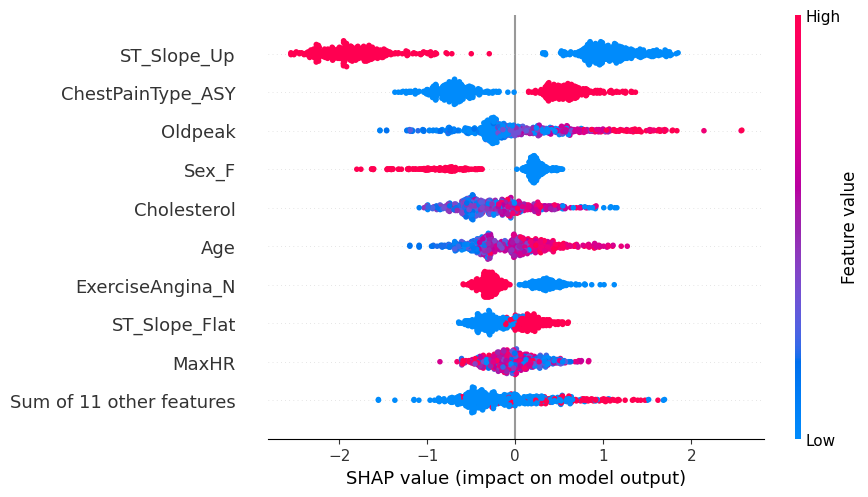

In [ ]:
# Produz um modelo com os dados de treinamento
model = xgboost.XGBClassifier(n_estimators = 20)
model.fit(ind_train, obj_train)

# Produz a explicação do modelo por meio do método SHAP
explainer = shap.Explainer(model)
shap_values = explainer(new_df)
shap.plots.beeswarm(shap_values)

## DiCE (Diverse Counterfactual Explanations)

In [ ]:
import dice_ml
import random

In [ ]:
# Indica as características que serão analisadas
features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

# Analisa os dados
df_dice = dice_ml.Data(dataframe = df, continuous_features = features, outcome_name = 'HeartDisease')

In [ ]:
# Constrói o modelo em cima dos dados
rf_dice = dice_ml.Model(model = rf, backend = "sklearn")

# Gera a explicação
explainer = dice_ml.Dice(df_dice, rf_dice, method = "random")

### Encontra um contrafato para um indivíduo específico

In [ ]:
from raiutils.exceptions import UserConfigValidationException

In [ ]:
try:
  input_point = int(input("Escolha um individuo pelo indice: "))

  input_data = ind_test[input_point : input_point + 1].copy().astype(float)
  cf = explainer.generate_counterfactuals(input_data, total_CFs = 6, desired_class = "opposite")

  cf.visualize_as_dataframe(show_only_changes = True)

except UserConfigValidationException as e:
  print("Nao foi possivel encontrar um contrafato para esse individuo")

Escolha um individuo pelo indice: 42


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

Query instance (original outcome : 1)


,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,...,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,67.0,152.0,212.0,0.0,150.0,0.8,1



Diverse Counterfactual set (new outcome: 0)


,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,...,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,-,-,-,-,-,-,-,-,-,-,...,-,0.0,-,-,-,-,-,-,-,0.0
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,113.0,-,-,-,-,0.0
2,-,-,-,-,-,-,0.0,-,-,-,...,-,-,-,-,47.0,-,-,-,-,0.0
3,-,-,-,-,-,-,-,-,1.0,-,...,-,-,1.0,-,-,-,-,-,-,0.0
4,1.0,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,0.0
5,-,0.0,-,-,-,-,-,-,-,-,...,-,-,-,-,72.0,-,-,-,-,0.0


### Cria um contrafato condicional

In [ ]:
# Seleciona as variáveis a serem alteradas no contrafatos
features = ['ChestPainType_ASY', 'ExerciseAngina_Y', 'ST_Slope_Up', 'Oldpeak', 'RestingBP']

# Estabelece intervalos de vaçpres ára algumas variáveis não-binárias
ranges = {'Oldpeak': [-2.5, 5.0], 'RestingBP': [0, 200]}

# Produz o contrafato
cf = explainer.generate_counterfactuals(input_data, total_CFs = 5,
                                  desired_class = "opposite", permitted_range = ranges,
                                  features_to_vary = features)

cf.visualize_as_dataframe(show_only_changes = True)

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]

Query instance (original outcome : 1)


,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,...,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,67.0,152.0,212.0,0.0,150.0,0.8,1



Diverse Counterfactual set (new outcome: 0)


,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,...,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,33.0,-,-,-,-,0.0
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,90.0,-,-,-,-,0.0
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,99.0,-,-,-,-,0.0
3,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,55.0,-,-,-,-,0.0
4,-,-,-,-,-,-,-,-,-,-,...,-,-,1.0,-,-,-,-,-,0.5,0.0
